# LENET MODEL for Classification with PyTorch

เราจะมาลองสร้าง LENET MODEL ซึ่งเป็น CNN model ตัวแรกๆ ขนาดใหญ่ขึ้นมาจาก simple CNN อีกหน่อย ใช้สำหรับงาน classification

ขั้นตอนในการสร้างโมเดล
1. data exploration
2. data correction
3. data preparation
4. load data
5. define model architecture
6. train model
7. K-fold cross validation
8. visualize feature map
9. mode evaluation

In [ ]:
import torch.nn as nn
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader,SubsetRandomSampler
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy
import cv2
import os
import matplotlib.pyplot as plt
from glob import glob
from sklearn.model_selection import train_test_split
import shutil
from PIL import ImageFile
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# DATA EXPLORATION

## Section 1: Exploring Image Data

ในส่วนนี้ เราจะเริ่มต้นด้วยการสำรวจข้อมูลภาพที่เราจะใช้ตลอดการฝึกหัดนี้ การทำความเข้าใจโครงสร้างและเนื้อหาของข้อมูลที่เราจะใช้ เป็นสิ่งสำคัญ ก่อนที่จะเข้าสู่การฝึกโมเดล โดยสามารถโหลดชุดข้อมูลภาพตัวอย่าง นำมาแสดงตัวอย่างของค่าที่ต้องการสำรวจของภาพบางส่วน และตรวจสอบคุณสมบัติต่างๆ โดยเฉพาะ คุณสมบัติของภาพต่อไปนี้:

1. **Image Resolution**: ขนาดความละเอียดของภาพ (ความกว้างและความสูงเป็นพิกเซล) การทำความเข้าใจขนาดและความละเอียดของภาพของคุณเป็นสิ่งสำคัญสำหรับการเตรียมข้อมูลล่วงหน้าและความต้องการของอินพุตโมเดล ขนาดภาพข้อมูลที่แตกต่างจากขนาดภาพที่โมเดลรับเข้า ทำให้ต้องเตรียมปรับขนาดภาพก่อนเข้า ซึ่งจะส่งผลต่อรายละเอียดของภาพที่อาจเปลี่ยนไป
2. **Aspect Ratio**: อัตราส่วนของภาพ (ความกว้างต่อความสูง) บอกสัดส่วนว่าภาพกว้างและสูงใกล้เคียงกันหรือไม่ หากแตกต่างกันมากแสดงว่าภาพจะไม่ใช่ภาพสี่เหลี่ยมจตุรัส แต่เป็นภาพสี่เหลี่ยมผืนผ้าแนวนอน หรือแนวตั้ง ซึ่งหากต้องการเปลี่ยนเป็นภาพจตุรัส โดยไม่ระวัง วัตถุในภาพอาจมีรูปร่างลักษณะที่แปลกจากความเป็นจริง และเมื่อนำไปสอนโมเดลแล้ว โมเดลอาจเข้าใจวัตถุนั้นผิดไป
3. **Statistics of Brightness**: วิเคราะห์ระดับความสว่างของภาพโดยคำนวณสถิติต่างๆ เช่น ค่าเฉลี่ย ค่ามัธยฐาน และส่วนเบี่ยงเบนมาตรฐานของค่าความเข้มของพิกเซล ซึ่งจะช่วยให้เข้าใจลักษณะของภาพที่เข้ามาสอนโมเดล เช่น ความสว่าง หรือความคมชัดของชุดข้อมูลภาพ ซึ่งค่านี้สามารถนำไปใช้ในการ Normalize รูปภาพ ด้วยเทคนิคการปรับขนาดความเข้มแสงแบบ Standardized data ด้วยค่าเฉลี่ยและค่าเบี่ยงเบนมาตรฐาน หรือเทคนิคการปรับขนาดความเข้มแสงแบบ Max-Min Normalize ซึ่งใช้ค่าสูงสุดและต่ำสุดของค่าแสงของจุดภาพหรือพิกเซลภาพทั้งหมดในชุดข้อมูลภาพ (image dataset)
4. **Color Channels**: ตรวจสอบช่องสี (เช่น RGB) ของภาพ ตรวจสอบให้แน่ใจว่าภาพมีจำนวนช่องที่ถูกต้องและเข้าใจว่าข้อมูลสีถูกแจกจ่ายอย่างไร
5. **Class Distribution**: ประเมินจำนวนภาพในแต่ละคลาสเพื่อตรวจสอบความสมดุล (Balanced Classes) หรือไม่สมดุล (Imbalanced Classes) ในชุดข้อมูล ชุดข้อมูลที่สมดุลจะมีจำนวนภาพในแต่ละคลาสใกล้เคียงกัน ในขณะที่ชุดข้อมูลที่ไม่สมดุลจะมีความแตกต่างอย่างมาก ซึ่งอาจส่งผลต่อประสิทธิภาพของโมเดล
6. **Data Partitioning**: การแบ่งชุดข้อมูลออกเป็นชุด train, test, validate ด้วยค่า seed ที่แตกต่าง จะส่งผลในการสุ่มภาพไปยังชุดข้อมูลแต่ละชุดแตกต่างกัน ควรวิเคราะห์ผลของการแบ่งข้อมูลว่าการแบ่งข้อมูลส่งผลต่อสถิติของแต่ละส่วนอย่างไร ขั้นตอนนี้จะช่วยให้เข้าใจความแปรปรวนที่เกิดจากการสุ่มตัวอย่าง และมั่นใจว่าแต่ละส่วนเป็นตัวแทนของชุดข้อมูลทั้งหมด

การสำรวจลักษณะของข้อมูลตามข้างต้นนี้ จะทำให้เราเข้าใจลักษณะของข้อมูลภาพเชิงลึกยิ่งขึ้น ดังนั้นเราควรทำ data exploration เป็นขั้นตอนเบื้องต้น เพื่อสำรวจความผิดปกติของข้อมูล ช่วยให้เราสามารถวางขั้นตอนการแก้ไขข้อมูล data correction เพิ่มเติม  ก่อนนำไปใช้ในขั้นตอนการเตรียมข้อมูลต่อไป



In [ ]:
!curl -L -o THFOOD4.zip https://github.com/NextGen-AI-Camp/curriculum/releases/download/Dataset/THFOOD4.zip
!unzip -o  THFOOD4.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  149M  100  149M    0     0  55.6M      0  0:00:02  0:00:02 --:--:-- 99.4M
Archive:  THFOOD4.zip
   creating: THFOOD4/GaengJued/
  inflating: THFOOD4/GaengJued/001.jpg  
  inflating: THFOOD4/GaengJued/002.jpg  
  inflating: THFOOD4/GaengJued/003.jpg  
  inflating: THFOOD4/GaengJued/004.jpg  
  inflating: THFOOD4/GaengJued/005.jpg  
  inflating: THFOOD4/GaengJued/006.jpg  
  inflating: THFOOD4/GaengJued/007.jpg  
  inflating: THFOOD4/GaengJued/008.jpg  
  inflating: THFOOD4/GaengJued/009.jpg  
  inflating: THFOOD4/GaengJued/010.jpg  
  inflating: THFOOD4/GaengJued/011.jpg  
  inflating: THFOOD4/GaengJued/012.jpg  
  inflating: THFOOD4/GaengJued/013.jpg  
  inflating: THFOOD4/GaengJued/015.jpg  
  inflating: THFOOD4/GaengJued/016.jpg  
  inflating: TH

## Utility Functions for Data Exploration

ในส่วนนี้ จะเป็นฟังก์ชันที่ใช้สำหรับการสำรวจข้อมูลภาพ ที่ช่วยในการวิเคราะห์ข้อมูลภาพที่แยกเป็น train test validate ได้อย่างมีประสิทธิภาพ:

1. **Get Path of All Image Files**: ฟังก์ชันนี้จะดึงพาธของไฟล์ภาพทั้งหมดในชุดข้อมูล โดยการรวบรวมพาธของไฟล์ภาพจะช่วยให้สามารถเข้าถึงและจัดการกับภาพได้สะดวกยิ่งขึ้น

2. **Split Files into Train, Test, Validate Sets**: การแบ่งชุดข้อมูลออกเป็นสามส่วน ได้แก่ ชุดฝึก (train), ชุดตรวจสอบความถูกต้อง (validate), และชุดทดสอบ (test) โดยการใช้ seed สำหรับสุ่มที่แตกต่างกัน ฟังก์ชันนี้จะช่วยในการแบ่งข้อมูลอย่างเป็นระบบและสามารถวิเคราะห์ผลกระทบของการแบ่งข้อมูลต่อสถิติของแต่ละส่วน เมื่อ seed เปลี่ยนไปได้

3. **Count the Number of class images in each split**: ฟังก์ชันนี้จะนับจำนวนภาพในแต่ละคลาสที่ถูกแบ่งไปในแต่ละส่วน เพื่อให้เราสามารถตรวจสอบการกระจายของข้อมูลในแต่ละส่วนและตรวจสอบความสมดุลของชุดข้อมูลได้

4. **Center Crop to Preserve Aspect Ratio**: การตัดภาพจากกึ่งกลางเพื่อรักษาอัตราส่วนภาพก่อนที่จะปรับขนาดเป็นขนาดสี่เหลี่ยมจัตุรัส ฟังก์ชันนี้จะช่วยรักษาความสมบูรณ์ของภาพและป้องกันการบิดเบือนของอัตราส่วนภาพที่อาจทำให้วัตถุในภาพมีรูปร่างผิดเพี้ยนไป

5. **Calculate Image Statistics for each split**: ฟังก์ชันนี้จะคำนวณสถิติของภาพในแต่ละส่วน เช่น ความสว่างเฉลี่ยของภาพในระดับสีเทาและในแต่ละช่องสีแดง/เขียว/น้ำเงิน การคำนวณสถิติเหล่านี้จะช่วยในการวิเคราะห์คุณภาพและลักษณะของภาพในแต่ละส่วน

6. **Visualize Data**: ฟังก์ชันนี้จะรวบรวมข้อมูลทั้งหมดและแสดงภาพในรูปแบบกราฟเพื่อให้เราสามารถมองเห็นภาพรวมของข้อมูลได้อย่างชัดเจน การแสดงภาพกราฟจะช่วยในการทำความเข้าใจได้อย่างมีประสิทธิภาพ

โดยการใช้ฟังก์ชันเหล่านี้ ทำให้เราสามารถสำรวจและทำความเข้าใจข้อมูลภาพได้อย่างละเอียดถี่ถ้วน และเตรียมข้อมูลสำหรับการฝึกโมเดลการเรียนรู้เชิงลึกได้อย่างมีประสิทธิภาพ


In [ ]:
# Utility
def copy_files_to_new_folders(original_dataset_dir, train_files, test_files, val_files):
    splits = [('train', train_files), ('test', test_files), ('val', val_files)]
    for split_name, files in splits:
        split_dir = os.path.join(original_dataset_dir, split_name)
        for file_path in files:
            class_name = os.path.basename(os.path.dirname(file_path))
            new_file_path = os.path.join(split_dir, class_name, os.path.basename(file_path))
            os.makedirs(os.path.dirname(new_file_path), exist_ok=True)
            shutil.copyfile(file_path, new_file_path)

def get_file_paths(dataset_dir):
    subdirs = [os.path.join(dataset_dir, d) for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]

    file_paths = []
    for subdir in subdirs:
        file_paths.extend(glob(os.path.join(subdir, '*')))

    return file_paths

def split_dataset(file_paths, train_size=0.7, val_size=0.2,seed=42):
    train_files, test_files = train_test_split(file_paths, train_size=train_size, random_state=seed)
    train_files, val_files = train_test_split(train_files, test_size=val_size, random_state=seed)
    return train_files, test_files, val_files

def count_classes(file_list):
    class_counts = {}
    for file_path in file_list:
        class_name = os.path.basename(os.path.dirname(file_path))
        class_counts[class_name] = class_counts.get(class_name, 0) + 1
    return class_counts

def center_crop_image(img, target_size=(64, 64)):
    new_dim = target_size[0] + 3

    if img.shape[1] > img.shape[0]:
        aspect_ratio = img.shape[1] / img.shape[0]
        new_width = int(new_dim * aspect_ratio)
        resized_img = cv2.resize(img, (new_width, new_dim))
    else:
        aspect_ratio = img.shape[1] / img.shape[0]
        new_height = int(new_dim / aspect_ratio)
        resized_img = cv2.resize(img, (new_dim, new_height))

    width, height = resized_img.shape[1], resized_img.shape[0]
    crop_width = min(target_size[0], width)
    crop_height = min(target_size[1], height)
    mid_x, mid_y = width // 2, height // 2
    cw2, ch2 = crop_width // 2, crop_height // 2

    cropped_img = resized_img[mid_y - ch2: mid_y + ch2, mid_x - cw2: mid_x + cw2]

    return cropped_img

def prepare_data(dataset_dir,seed=42):
    file_paths = get_file_paths(dataset_dir)
    train_files, test_files, val_files = split_dataset(file_paths, train_size=0.7, val_size=0.2,seed=seed)
    print("Training files:", len(train_files))
    print("Testing files:", len(test_files))
    print("Validation files:", len(val_files))
    train_counts = count_classes(train_files)
    test_counts = count_classes(test_files)
    val_counts = count_classes(val_files)
    print("Training files per class:", train_counts)
    print("Testing files per class:", test_counts)
    print("Validation files per class:", val_counts)
    return [train_files, test_files, val_files]

def explore(image_paths,center_crop=False):
    dataset_width = []
    dataset_height = []
    dataset_channels = []
    dataset_aspect_ratio = []
    avg_brightness_gray =[]
    avg_brightness_r = []
    avg_brightness_g = []
    avg_brightness_b = []

    for filename in image_paths:
        img = cv2.imread(filename)
        if center_crop:
            img = center_crop_image(img)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            h, w, c = img.shape
            dataset_width.append(w)
            dataset_height.append(h)
            dataset_channels.append(c)
            dataset_aspect_ratio.append(w / h)
            red = np.mean(img[...,0])
            avg_brightness_r.append(red)
            green = np.mean(img[...,1])
            avg_brightness_g.append(green)
            blue = np.mean(img[...,2])
            avg_brightness_b.append(blue)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            avg_brightness_gr = np.mean(gray)
            avg_brightness_gray.append(avg_brightness_gr)
    return dataset_width,dataset_height,dataset_channels,dataset_aspect_ratio,avg_brightness_gray,avg_brightness_r,avg_brightness_g,avg_brightness_b

def compute_max_values(datasets):
    max_width = max_height = max_aspect_ratio = max_brightness_gray = max_brightness_rgb = float('-inf')

    for dataset in datasets:
        dataset_width, dataset_height, _, dataset_aspect_ratio, avg_brightness_gray, avg_brightness_r, avg_brightness_g, avg_brightness_b = explore(dataset)

        max_width = max(max_width, max(dataset_width))
        max_height = max(max_height, max(dataset_height))
        max_aspect_ratio = max(max_aspect_ratio, max(dataset_aspect_ratio))
        max_brightness_gray = max(max_brightness_gray, max(avg_brightness_gray))
        max_brightness_rgb = max(max_brightness_rgb, max(avg_brightness_r), max(avg_brightness_g), max(avg_brightness_b))

    return max_width, max_height, max_aspect_ratio, max_brightness_gray, max_brightness_rgb

def summary(dataset_dir,seed,center_crop=False):
    train_files, test_files, val_files = prepare_data(dataset_dir, seed=seed)
    max_len = 0
    for ele in [train_files, test_files, val_files]:
        max_len = max(max_len, len(ele))
    max_width, max_height, max_aspect_ratio, max_brightness_gray, max_brightness_rgb = compute_max_values([train_files, test_files, val_files])

    row_labels = ['Train', 'Test', 'Val']
    fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(10, 8))
    fig.suptitle(f'Dataset Exploration: Train, Test, and Validation Sets\nSEED: {seed}', fontsize=20, weight='bold')
    font_size = 6
    title_font_size = font_size + 2
    for index, dataset in enumerate([train_files, test_files, val_files]):
        dataset_width, dataset_height, _, dataset_aspect_ratio, avg_brightness_gray, avg_brightness_r, avg_brightness_g, avg_brightness_b = explore(dataset,center_crop=center_crop)

        ax[index, 0].scatter(dataset_width, dataset_height, marker='x',)
        ax[index, 0].plot([0, max_width+200], [0, max_width+200], color='red', label='aspect ratio = 1')
        ax[index, 0].legend(fontsize=font_size)
        ax[index, 0].set_xlim([0, max(max_width,max_height)+50])
        ax[index, 0].set_ylim([0, max(max_width,max_height)+50])
        ax[index, 0].tick_params(axis='both', labelsize=font_size)
        ax[index, 0].set_xlabel('Width', fontsize=font_size)
        ax[index, 0].set_ylabel('Height', fontsize=font_size)
        ax[index, 0].set_title('Scatter Plot of Dataset Width and Height', fontsize=font_size)

        ax[index, 1].hist(dataset_aspect_ratio)
        ax[index, 1].set_ylim([0, max_len+50])
        ax[index, 1].tick_params(axis='both', labelsize=font_size)
        ax[index, 1].set_xlabel('Aspect Ratio', fontsize=font_size)
        ax[index, 1].set_ylabel('Frequency', fontsize=font_size)
        ax[index, 1].set_title('Aspect Ratio Distribution', fontsize=font_size)

        ax[index, 2].boxplot(avg_brightness_gray, vert=False, patch_artist=True, showmeans=True)
        ax[index, 2].set_xlim([0, max_brightness_gray+50])
        ax[index, 2].tick_params(axis='both', labelsize=font_size)
        ax[index, 2].set_xlabel("Average Brightness", fontsize=font_size)
        ax[index, 2].set_title("Box Plot of Average Brightness for Images", fontsize=font_size)

        ax[index, 3].boxplot([avg_brightness_r, avg_brightness_g, avg_brightness_b], vert=False, patch_artist=True, showmeans=True)
        ax[index, 3].set_xlim([0, max_brightness_rgb+50])
        ax[index, 3].tick_params(axis='both', labelsize=font_size)
        ax[index, 3].set_xlabel("Average Brightness", fontsize=font_size)
        ax[index, 3].set_yticklabels(['R', 'G', 'B'], fontsize=font_size)
        ax[index, 3].set_title("Box Plot of Average Brightness for Images", fontsize=font_size)

        ax[index, 0].text(-0.5, 0.5, row_labels[index],  fontsize=font_size, weight='bold', transform=ax[index, 0].transAxes)

    plt.tight_layout()
    plt.show()

Training files: 1028
Testing files: 552
Validation files: 257
Training files per class: {'YamWoonSen': 282, 'KkaoKlukKaphi': 247, 'GoongPao': 252, 'GaengJued': 247}
Testing files per class: {'GoongPao': 135, 'KkaoKlukKaphi': 136, 'GaengJued': 149, 'YamWoonSen': 132}
Validation files per class: {'GoongPao': 56, 'GaengJued': 72, 'KkaoKlukKaphi': 65, 'YamWoonSen': 64}


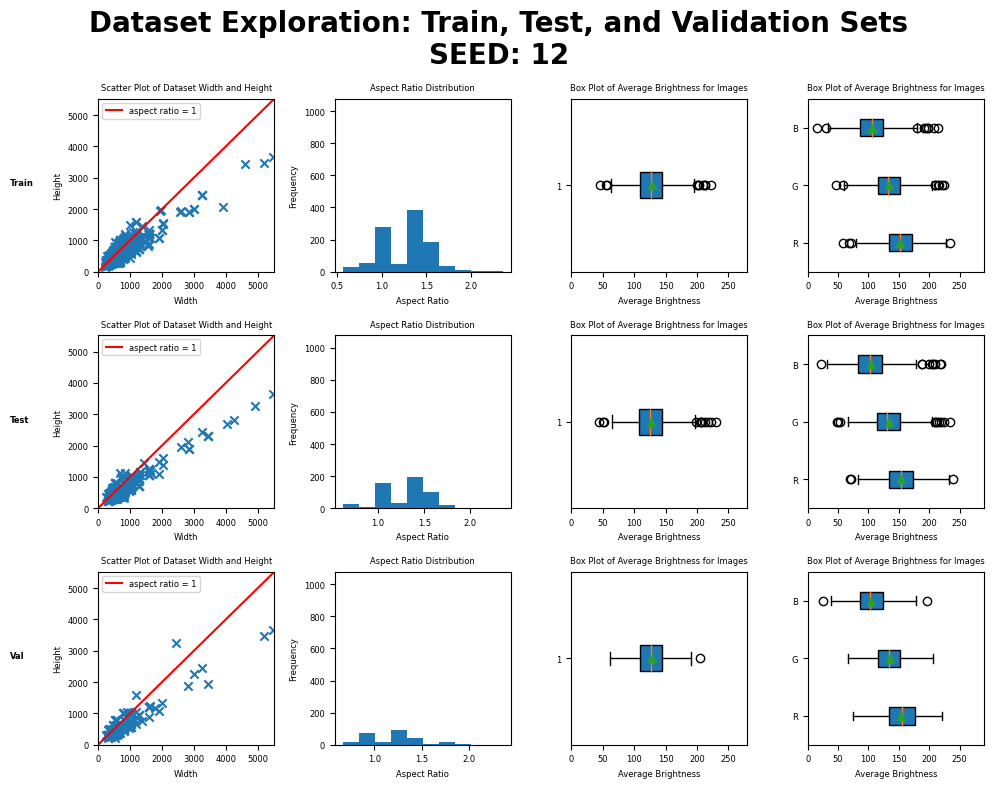

Training files: 1028
Testing files: 552
Validation files: 257
Training files per class: {'GoongPao': 243, 'GaengJued': 267, 'YamWoonSen': 261, 'KkaoKlukKaphi': 257}
Testing files per class: {'GaengJued': 139, 'YamWoonSen': 146, 'KkaoKlukKaphi': 139, 'GoongPao': 128}
Validation files per class: {'GoongPao': 72, 'GaengJued': 62, 'KkaoKlukKaphi': 52, 'YamWoonSen': 71}


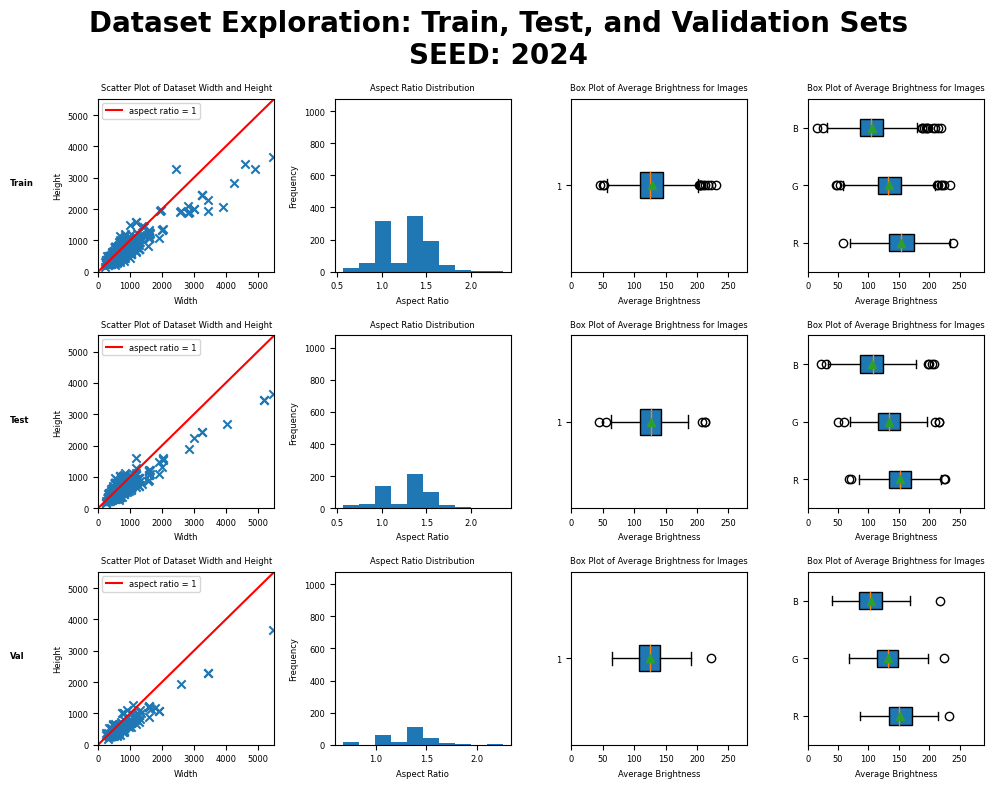

Training files: 1028
Testing files: 552
Validation files: 257
Training files per class: {'KkaoKlukKaphi': 240, 'YamWoonSen': 274, 'GoongPao': 252, 'GaengJued': 262}
Testing files per class: {'YamWoonSen': 134, 'GaengJued': 136, 'KkaoKlukKaphi': 148, 'GoongPao': 134}
Validation files per class: {'YamWoonSen': 70, 'KkaoKlukKaphi': 60, 'GaengJued': 70, 'GoongPao': 57}


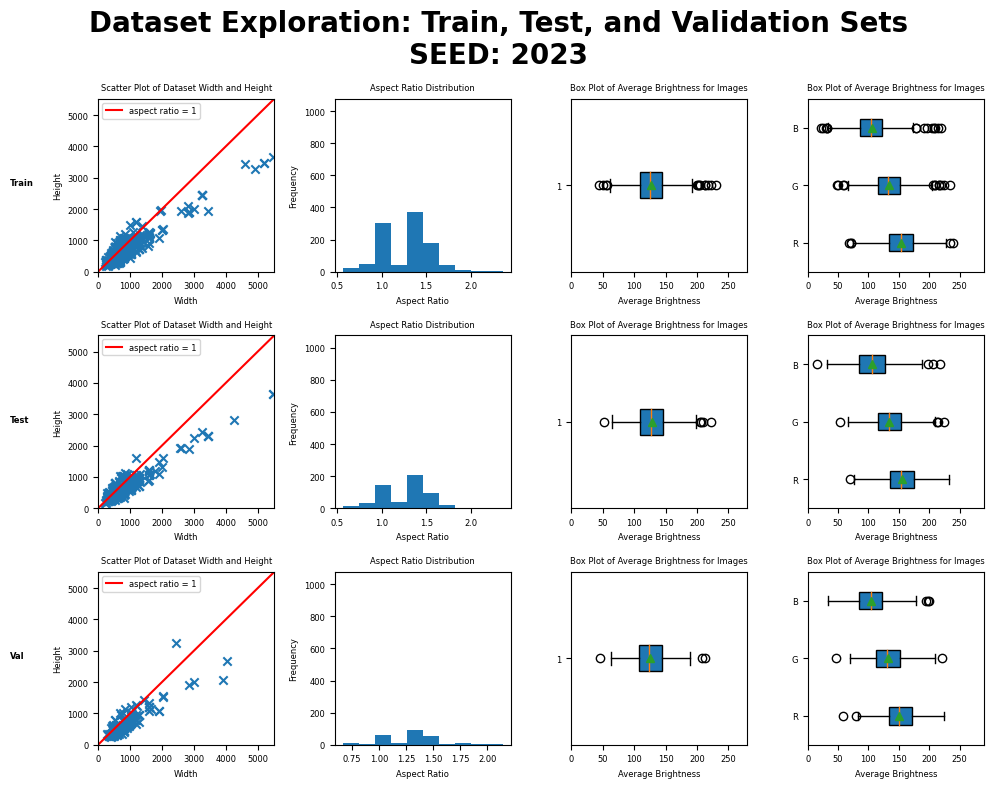

In [ ]:
dataset_dir = "/content/THFOOD4"
summary(dataset_dir,12)
summary(dataset_dir,2024)
summary(dataset_dir,2023)


Training files: 1028
Testing files: 552
Validation files: 257
Training files per class: {'YamWoonSen': 282, 'KkaoKlukKaphi': 247, 'GoongPao': 252, 'GaengJued': 247}
Testing files per class: {'GoongPao': 135, 'KkaoKlukKaphi': 136, 'GaengJued': 149, 'YamWoonSen': 132}
Validation files per class: {'GoongPao': 56, 'GaengJued': 72, 'KkaoKlukKaphi': 65, 'YamWoonSen': 64}


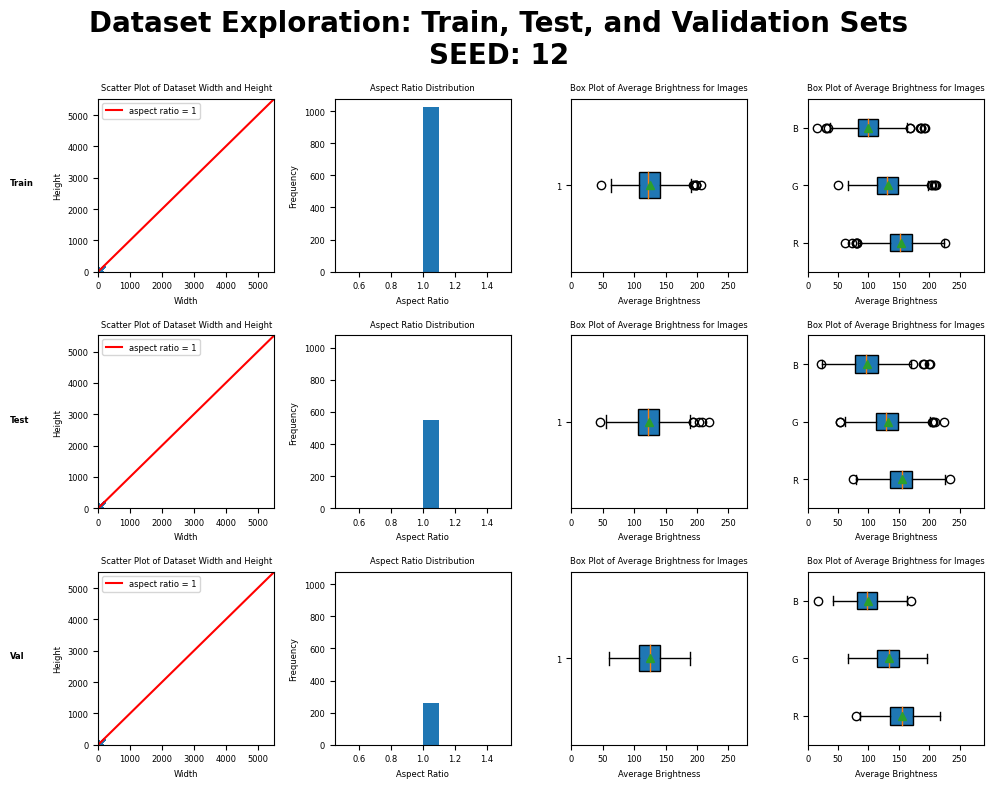

In [ ]:
dataset_dir = "/content/THFOOD4"
summary(dataset_dir,12,center_crop=True)

# DATA CORRECTION
- ASPECT RATIO → CENTER CROP


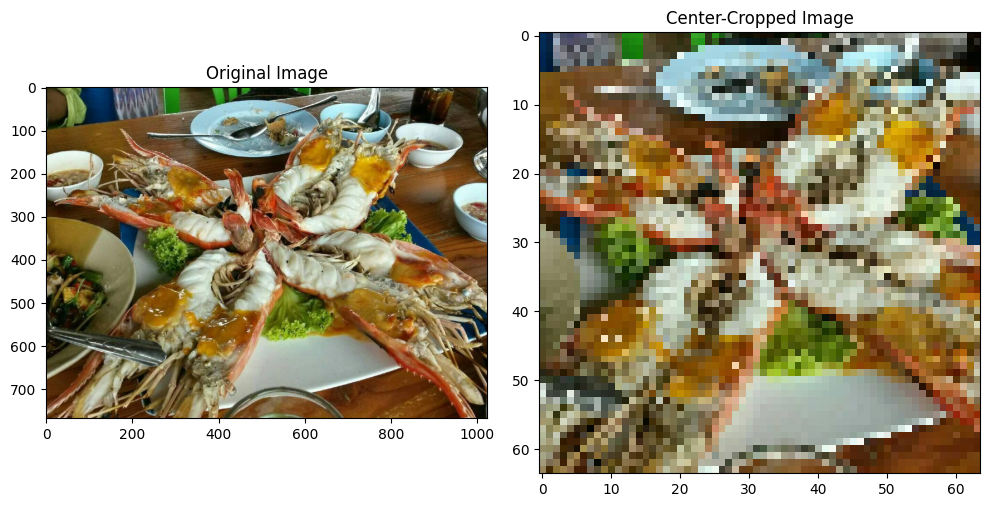

In [ ]:
og_img = cv2.imread('/content/THFOOD4/GoongPao/091.jpg')
og_img = cv2.cvtColor(og_img,cv2.COLOR_BGR2RGB)
img = center_crop_image(og_img,(64,64))
ig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Display the original image
ax[0].imshow(og_img)
ax[0].set_title('Original Image')

# Display the center-cropped image
ax[1].imshow(img)
ax[1].set_title('Center-Cropped Image')


plt.tight_layout()
plt.show()

In [ ]:
seed = 12
dataset_dir = "/content/THFOOD4"
train_files, test_files, val_files = prepare_data(dataset_dir, seed=seed)

copy_files_to_new_folders(f'/content/seed{seed}', train_files, test_files, val_files)

Training files: 1028
Testing files: 552
Validation files: 257
Training files per class: {'YamWoonSen': 282, 'KkaoKlukKaphi': 247, 'GoongPao': 252, 'GaengJued': 247}
Testing files per class: {'GoongPao': 135, 'KkaoKlukKaphi': 136, 'GaengJued': 149, 'YamWoonSen': 132}
Validation files per class: {'GoongPao': 56, 'GaengJued': 72, 'KkaoKlukKaphi': 65, 'YamWoonSen': 64}


---

# DATA PREPARATION
เป็นขั้นตอนสำคัญในการเตรียมข้อมูลเพื่อให้ได้ข้อมูลที่ดีและมีความหลากหลายเพียงพอ ช่วยให้โมเดลสามารถเรียนรู้และทำนายได้แม่นยำมากขึ้น หนึ่งในกระบวนการสำคัญในขั้นตอนการเตรียมข้อมูลคือ Data Augmentation

### Data Augmentation

เป็นกระบวนการในการเพิ่มความหลากหลายของชุดข้อมูล โดยการแปลงภาพต้นฉบับเป็นภาพใหม่ด้วยวิธีการต่างๆ ซึ่งช่วยให้โมเดลสามารถเรียนรู้จากข้อมูลที่หลากหลายและมีความทนทานต่อการเปลี่ยนแปลงในข้อมูลที่ใช้ทำนาย การเพิ่มความหลากหลายของข้อมูลสามารถทำได้หลายวิธี ดังนี้:

1. **Random Resize**: การปรับขนาดของภาพแบบสุ่ม เพื่อสร้างภาพที่มีขนาดแตกต่างกัน วิธีนี้จะช่วยให้โมเดลสามารถจัดการกับภาพที่มีขนาดต่างกันได้ดีขึ้น
2. **Padding**: การเติมขอบให้กับภาพ อาจใช้สีดำหรือสีอื่นๆ ขึ้นอยู่กับความต้องการ ในที่นี้จะใช้รูปแบบ reflect padding เพื่อการเติมข้อมูลนอกกรอกภาพเดิม เป็นแบบคล้ายกระจกสะท้อน เพื่อให้เมื่อนำไป random affine transform ส่วนที่ล้นนอกกรอบภาพเดิม จะมีเนื้อภาพที่เติมติดไป ช่วยให้สถิติของภาพไม่เพี้ยนไปมาก เท่ากับการเติมด้วยศูนย์ (zero padding)
3. **RandomAffine**: เป็นการแปลงภาพแบบ Affine Transformation จะเป็นการแปลงเชิงเส้นที่รักษาความขนานของเส้นตรงไว้ การแปลงแบบนี้รวมถึงการแปลงแบบพื้นฐานหลายแบบซึ่งสามารถทำได้โดยการสุ่มพารามิเตอร์ ดังนี้:
   - **การหมุน (Rotation)**: การหมุนภาพตามมุมที่สุ่มเลือก ซึ่งสามารถช่วยให้โมเดลรับรู้ภาพในมุมมองการรับภาพต่างๆ ได้ดีขึ้น
   - **การเลื่อน (Translation)**: การเลื่อนภาพในแนวนอนและแนวตั้งตามระยะทางที่สุ่มเลือก จะช่วยให้โมเดลสามารถจำลองวัตถุที่อยู่ในตำแหน่งต่างๆในภาพได้
   - **การปรับขนาด (Scaling)**: การขยายหรือย่อภาพตามอัตราที่สุ่มเลือก จะช่วยให้โมเดลสามารถรับรู้วัตถุที่มีขนาดแตกต่างกันได้
   - **การเฉือน (Shearing)**: การเฉือนภาพตามมุมที่สุ่มเลือก จะช่วยให้โมเดลสามารถรับรู้วัตถุที่มีรูปร่างแตกต่างกันได้
4. **Center Crop**: การครอบภาพจากกึ่งกลาง เพื่อรักษาอัตราส่วนของภาพและปรับขนาดของภาพให้อยู่ในขนาดที่ต้องการ วิธีนี้จะช่วยให้ภาพอยู่ในสัดส่วนที่ถูกต้องและสามารถนำไปใช้ในการฝึกโมเดลได้อย่างมีประสิทธิภาพ

data augmentation ถือเป็นเทคนิคที่มีประโยชน์มากในการเพิ่มขนาดและความหลากหลายของชุดข้อมูล โดยเฉพาะเมื่อข้อมูลมีจำกัด การเพิ่มตัวอย่างใหม่ที่หลากหลายจะช่วยให้โมเดลสามารถเรียนรู้ได้จากข้อมูลที่มากขึ้นและลดการเกิด overfitting ที่จำรูปแบบข้อมูลที่มีจำกัด แทนที่จะยืดหยุ่นพอที่จะเรียนรู้สิ่งที่แตกต่าง ด้วยการใช้เทคนิคการเตรียมข้อมูลและการเสริมข้อมูลเหล่านี้ เราจะสามารถปรับปรุงประสิทธิภาพของโมเดลการเรียนรู้เชิงลึกได้อย่างมีนัยสำคัญ และสร้างโมเดลที่สามารถทำงานได้ดีในสถานการณ์ที่หลากหลายได้

In [ ]:
def load_data(path,is_test=False):
    torch.manual_seed(4912)

    if is_test:
        transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((64, 64)),
        ])
        dataset = ImageFolder(path, transform=transform)

    else:
        transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((66, 66)),
        transforms.Pad(65, padding_mode='reflect'),
        transforms.RandomAffine(degrees=15, translate=(0.05, 0.05),scale=(0.8, 1.2), shear=10),
        transforms.CenterCrop(64),
        ])
        dataset = ImageFolder(path, transform=transform)
    class_names = dataset.classes
    print("class_names",class_names)
    data_loader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=16, pin_memory=True)

    print("📃Dataset:")
    class_counts_train = [0] * len(class_names)
    for _, target in dataset:
        class_counts_train[target] += 1

    for class_name, class_count in zip(class_names, class_counts_train):
        print(f"\tNumber of images in class {class_name}: {class_count}")

    print(f"\tNumber of samples: {len(dataset)}")

    return dataset

In [ ]:
train_dataset = load_data('/content/seed12/train')
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=16, pin_memory=True)
test_dataset = load_data('/content/seed12/test',is_test=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=16, pin_memory=True)
val_dataset = load_data('/content/seed12/val',is_test=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True, num_workers=16, pin_memory=True)


class_names ['GaengJued', 'GoongPao', 'KkaoKlukKaphi', 'YamWoonSen']
📃Dataset:


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


	Number of images in class GaengJued: 247
	Number of images in class GoongPao: 252
	Number of images in class KkaoKlukKaphi: 247
	Number of images in class YamWoonSen: 282
	Number of samples: 1028
class_names ['GaengJued', 'GoongPao', 'KkaoKlukKaphi', 'YamWoonSen']
📃Dataset:
	Number of images in class GaengJued: 149
	Number of images in class GoongPao: 135
	Number of images in class KkaoKlukKaphi: 136
	Number of images in class YamWoonSen: 132
	Number of samples: 552
class_names ['GaengJued', 'GoongPao', 'KkaoKlukKaphi', 'YamWoonSen']
📃Dataset:
	Number of images in class GaengJued: 72
	Number of images in class GoongPao: 56
	Number of images in class KkaoKlukKaphi: 65
	Number of images in class YamWoonSen: 64
	Number of samples: 257


In [ ]:
def imshow_grid(images, labels, class_names):
    num_images = len(images)
    num_rows = int(np.ceil(np.sqrt(num_images)))
    num_cols = int(np.ceil(num_images / num_rows))

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6),dpi=100)
    for i, ax in enumerate(axes.flat):
        if i < num_images:
            image = images[i].permute(1, 2, 0)
            label = labels[i].item()
            ax.imshow(torch.clamp(image,0,1))
            ax.set_title(class_names[label])
            ax.axis('off')
        else:
            ax.axis('off')
    plt.tight_layout()
    plt.show()

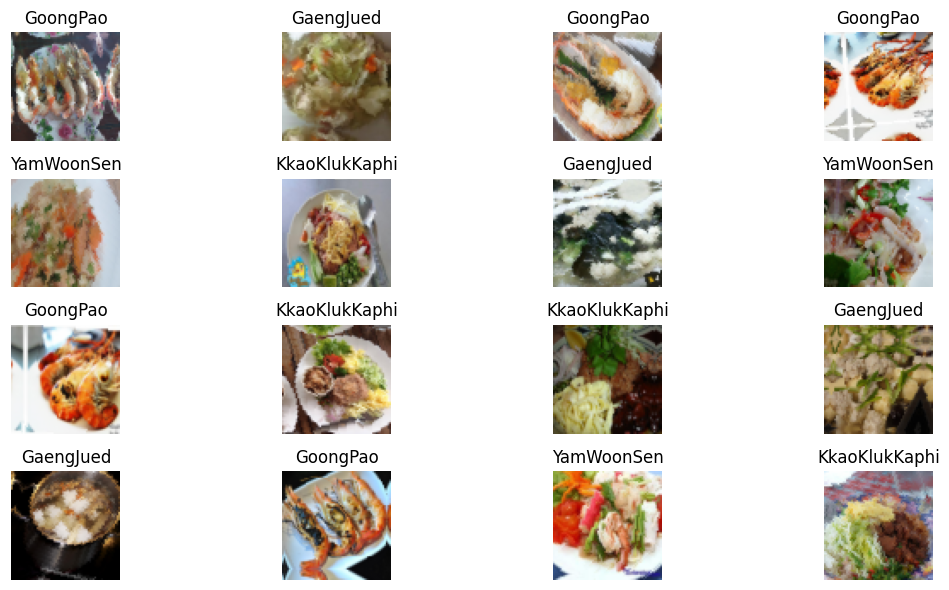

In [ ]:
class_names = ['GaengJued', 'GoongPao', 'KkaoKlukKaphi', 'YamWoonSen']
batch, labels = next(iter(train_loader))
imshow_grid(batch, labels, class_names)

# MODEL ARCHITECTURE
## LeNet Model Architecture

![lenet.jpg](https://github.com/NextGen-AI-Camp/curriculum/blob/main/Week%235/CNN%232/asset/lenet.jpg?raw=true)

https://www.naukri.com/code360/library/lenet-5

LeNet เป็นหนึ่งในสถาปัตยกรรมของ Convolutional Neural Network (CNN) ที่ได้รับความนิยมในการจดจำภาพ โดย LeNet ถูกพัฒนาขึ้นโดย Yann LeCun และคณะในปี 1998 สำหรับการจำแนกตัวเลขที่เขียนด้วยลายมือ (MNIST dataset) สถาปัตยกรรมของ LeNet ประกอบด้วยเลเยอร์หลายชั้นซึ่งทำงานร่วมกันเพื่อแยกคุณสมบัติที่มีความสำคัญจากภาพ

### โครงสร้างของ LeNet

LeNet ประกอบด้วยเลเยอร์หลักดังนี้:
1. **Convolutional Layer 1 (C1)**: ใช้ kernel weights ขนาด 5x5 จำนวน 6 ตัว ทำให้ได้ 6 feature maps ขนาด 28x28 จะสังเกตว่าขนาดของผลลัพธ์ลดลงจากขนาดภาพอินพุท เนื่องจากไม่มีการทำ padding ก่อนทำ convolution ในตัวกรอง
2. **Subsampling Layer 1 (S2)**: ใช้การทำ Average Pooling ขนาด 2x2 ลดขนาด feature maps ลงครึ่งหนึ่งเป็น 14x14
3. **Convolutional Layer 2 (C3)**: ใช้ตัวกรองขนาด 5x5 จำนวน 16 ตัว ทำให้ได้ 16 feature maps ขนาด 10x10 (no padding เช่นเดียวกันกับ C1)
4. **Subsampling Layer 2 (S4)**: ใช้การทำ Average Pooling ขนาด 2x2 ลดขนาด feature maps ลงครึ่งหนึ่งเป็น 5x5
5. **Fully Connected Layer 1 (F5)**: แปลง feature maps เป็น vector และเชื่อมต่อเข้ากับ Neuron จำนวน 120 ตัว
6. **Fully Connected Layer 2 (F6)**: เชื่อมต่อ Neuron จำนวน 120 ตัวไปยัง Neuron จำนวน 84 ตัว
7. **Output Layer**: ใช้ Softmax เพื่อจำแนก 10 คลาส (สำหรับ MNIST)

โดยในการจำลองโมเดลใน code ด้านล่างนี้ จะใช้ภาพอินพุทขนาด 64x64 เพื่อให้วัตถุไม่เล็กจนเกินไป
### ผลกระทบของจำนวนเลเยอร์และขนาดของ output channel

**จำนวนเลเยอร์และขนาดของ output channel** มีผลกระทบต่อประสิทธิภาพของโมเดลอย่างมาก เลเยอร์ที่มากขึ้นและขนาดของ output channel ในแต่ละ Layer ที่มากขึ้นสามารถช่วยให้โมเดลสามารถแยกคุณสมบัติที่ซับซ้อนจากภาพได้ดีขึ้น แต่ในขณะเดียวกันก็อาจทำให้โมเดลมีความซับซ้อนมากขึ้นและต้องใช้ทรัพยากรในการคำนวณมากขึ้นด้วย

- **เลเยอร์เริ่มต้นควรมีขนาดเล็กกว่าหรือใหญ่กว่าเลเยอร์ต่อมาหรือไม่?** เลเยอร์เริ่มต้นควรมีขนาดเล็กกว่าเลเยอร์ต่อมา เหตุผลคือเลเยอร์เริ่มต้นจะทำการตรวจจับคุณสมบัติพื้นฐานเช่น ขอบ เส้น และรูปทรงง่ายๆ ในขณะที่เลเยอร์ต่อมาจะทำการตรวจจับคุณสมบัติที่ซับซ้อนมากขึ้น เช่น การรวมกันของรูปแบบพื้นฐานจากเลเยอร์ก่อนหน้า เพื่อประกอบเป็นโครงสร้างของวัตถุ ขนาดของ output channel ในเลเยอร์ต่อมาจึงควรเพิ่มขึ้นเพื่อให้สามารถจับคุณสมบัติที่ซับซ้อนได้มากขึ้น ตัวอย่างเช่น ใน LENET model ขนาดของ output channels หรือ convolutional nodes ในเลเยอร์แรกเริ่มจาก 6 channels ไปเป็น 16 channels ในเลเยอร์ที่สอง การเพิ่มขึ้นของจำนวน channel นี้จะช่วยให้โมเดลสามารถแยกคุณสมบัติที่ซับซ้อนได้มากขึ้น เมื่อผ่านเลเยอร์ไป

### เหตุผลที่โมเดลมีเลเยอร์ subsampling เช่น Average / Max Pooling

การมีเลเยอร์ subsampling เช่น Average / Max Pooling มีความสำคัญใน CNN สำหรับการลดขนาดเชิงพื้นที่ของแผนที่คุณลักษณะ การลดขนาดนี้ช่วยใน:
   - **การลดมิติการประมวลผล**: ลดภาระการคำนวณและการใช้หน่วยความจำ
   - **เทคนิคการประมวลผลแบบพีระมิด**: คล้ายกับเทคนิคการสร้างพีระมิดภาพ โดยการปรับลดขนาดภาพเพื่อช่วยลดขนาดวัตถุ ทำให้สามารถตรวจจับวัตถุที่มีขนาดใหญ่ขึ้นได้ด้วยตัวกรองหรือ Kernel weights ขนาดเท่าเดิม   ช่วยให้โมเดลสามารถประมวลผลคุณลักษณะที่มีความละเอียดและขนาดที่แตกต่างกันได้ โดยไม่เสียเวลาประมวลผลมาก นี่เป็นประโยชน์โดยเฉพาะในการรับรู้วัตถุในขนาดและตำแหน่งที่แตกต่างกันภายในภาพ
   - **การยืดหยุ่นต่อการเปลี่ยนแปลง**: การสรุปคุณลักษณะเชิงสถิติ เช่น Average/Max pooling ในพื้นที่ย่อย ช่วยให้ลดผลกระทบต่อการเปลี่ยนแปลงในพื้นที่ย่อยนั้น และช่วยให้โมเดลความทนทานต่อการแปลและการบิดเบือนเล็กน้อยในภาพ

โดยสรุป สถาปัตยกรรม LeNet ถูกออกแบบด้วยการเพิ่มจำนวน output channels อย่างค่อยเป็นค่อยไปและการลดขนาดของแผนที่คุณลักษณะเพื่อจับคุณลักษณะที่ซับซ้อนได้อย่างมีประสิทธิภาพ การใช้หลากหลายเลเยอร์ช่วยให้โมเดลจัดการกับภาพที่มีความละเอียดและขนาดที่แตกต่างกันได้ ซึ่งช่วยเพิ่มความทนทานและประสิทธิภาพของโมเดล

### เหตุผลการไม่ใส่ Activation Function ที่ Output Node สำหรับปัญหา Multiclass Classification

สำหรับปัญหา Multi-class classification เราเลือกใช้ Loss เป็น
nn.CrossEntropyLoss ใน PyTorch ซึ่งต้องการนำเข้าค่า output logits โดยมีฟังก์ชัน softmax และ negative log-likelihood รวมไว้ภายใน โดย Softmax: จะทำการแปลง logits เป็นความน่าจะเป็นให้กับ Negative Log-Likelihood Loss เพื่อเลี่ยงปัญหาจาก floating point precision และโอการการเกิด underflow หรือ overflow error.


In [ ]:
class CustomLeNet5(nn.Module):
    def __init__(self,input_size=(3,64,64)):
        super(CustomLeNet5, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=input_size[0], out_channels=6, kernel_size=5, stride=1, padding=2)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(self._get_input_size_fc1(input_size), 120)
        self.relu3 = nn.ReLU()

        self.fc2 = nn.Linear(120, 84)
        self.relu4 = nn.ReLU()

        self.fc3 = nn.Linear(84, 4)

    def _get_input_size_fc1(self, input_shape):
        with torch.no_grad():
            x = torch.zeros(1, *input_shape)
            x = self.conv1(x)
            x = self.relu1(x)
            x = self.pool1(x)

            x = self.conv2(x)
            x = self.relu2(x)
            x = self.pool2(x)

            x = self.flatten(x)
        return x.size(1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.flatten(x)

        x = self.fc1(x)
        x = self.relu3(x)

        x = self.fc2(x)
        x = self.relu4(x)

        x = self.fc3(x)
        return x

## Train
### กระบวนการฝึกโมเดล
ขั้นตอนสำคัญระหว่างฝึกโมเดลคือ กระบวนการปรับค่า weight จากขั้นตอนการทำ Backpropagation

ตัวอย่างสมการ Backpropagation:
- สำหรับค่าการสูญเสีย ($L$), เอาต์พุต ($y$), และน้ำหนัก ($W$):\
$\dfrac{\partial L}{\partial W}$ = $\dfrac{\partial L}{\partial y}$ $\cdot$ $\dfrac{\partial y}{\partial W}$ = $\dfrac{\partial L}{\partial y}$ $\cdot$ $\dfrac{\partial y}{\partial Z}$$\cdot$ $\dfrac{\partial Z}{\partial W}$

**การอัปเดตน้ำหนัก (Weight Update)**: ปรับน้ำหนักโดยใช้อัลกอริทึมของตัวปรับค่าที่เหมาะสม\
$W_{new}$ = $W_{old}$ - $\alpha$ $\cdot$ $\dfrac{\partial L}{\partial W}$\
โดยที่ $apha$ คืออัตราการเรียนรู้

### ผลของ Epoch และ Batch Size ต่อประสิทธิภาพของโมเดล

1. **Epoch**: จำนวนรอบที่โมเดลได้เห็นชุดข้อมูลฝึกทั้งหมด
   - Epoch มากเกินไปอาจทำให้โมเดล overfit ได้
   - Epoch น้อยเกินไปอาจทำให้โมเดล underfit ได้
จึงจำเป็นต้องมีการทดลองเพื่อเลือก Epoch ให้เหมาะสม
2. **Batch Size**: จำนวนตัวอย่างที่ใช้ในการคำนวณ Gradient และอัปเดตน้ำหนักในแต่ละครั้ง
   - Batch Size ใหญ่: ทำให้มีตัวอย่างมากพอในการเรียนรู้แต่ละรอบ ทำให้โมเดลการเรียนรู้ได้เสถียรกว่า แต่แลกมาด้วยการใช้หน่วยความจำมาก
   - Batch Size เล็ก: มีตัวอย่างในการเรียนรู้น้องในแต่ละรอบ ทำให้การเรียนรู้ที่เร็วกว่า แต่ไม่เสถียร แต่สามารถทำงานด้วยหน่วยความจำขนาดเล็กได้ จึงเป็นอีกหนึ่งพารามิเตอร์ที่ต้องปรับในการสอนโมเดล โดยต้องปรับให้ใหญ่พอที่จะทำงานในอุปกรณ์ที่ใช้

### อาการที่บ่งชี้ว่าโมเดล Overfit

1. **การ Loss ของชุด validate สูงขึ้น**: ขณะที่การ Loss ของชุด train ต่ำลง
2. **ความแตกต่างระหว่าง accuracy ของชุด train และชุด validate สูง**: accuracy ของชุดฝึกสูงมาก แต่ accuracy ของชุด validate ต่ำ

### การปรับค่า Learning Rate
่่
การใช้ learning rate schedule เป็นวิธีที่มีประสิทธิภาพในการปรับค่า Learning rate อย่างเหมาะสมระหว่างการฝึกโมเดล เพื่อช่วยให้โมเดลเรียนรู้ได้ดีขึ้นและหลีกเลี่ยงปัญหา เช่น overfitting หรือ ติดอยู่ใน local minima

### สัญญาณบ่งชี้ว่าควรปรับค่า Learning Rate

1. **การสูญเสีย (Loss) ไม่ลดลง**: หากค่า loss ของชุด train หรือชุด validate ไม่ลดลง อาจเป็นสัญญาณว่าค่า learning rate สูงเกินไปหรือทำให้การเรียนรู้ติดอยู่ใน local minima
2. **การสูญเสีย (Loss) แกว่งมาก**: หากค่า loss แกว่งขึ้นลงมาก อาจแสดงว่าค่า learning rate สูงเกินไปทำให้การปรับน้ำหนักไม่เสถียร
3. **การเปลี่ยนแปลงของค่า Loss ช้า**: หากการลดลงของค่า loss ช้ามาก อาจแสดงว่าค่า learning rate ต่ำเกินไปทำให้การปรับน้ำหนักช้า


### Learning Rate Schedule คืออะไร?
Learning rate schedule คือ การเปลี่ยนแปลงค่า Learning rate อย่างเป็นระบบในระหว่างการฝึกโมเดล โดยมีเป้าหมายเพื่อปรับปรุงประสิทธิภาพการฝึก การเปลี่ยนแปลงเหล่านี้สามารถทำได้ตามช่วงเวลา (epochs) หรือขึ้นอยู่กับประสิทธิภาพการทำงานของโมเดล (เช่น ค่า Loss ของ validation set) รูปแบบของ Learning Rate Schedule มีหลากหลายเทคนิค ได้แก่

1. **การลดค่า Learning Rate เมื่อไม่เกิดการปรับปรุง (Reduce on Plateau)**: ลดค่า learning rate เมื่อการสูญเสียของชุด validate ไม่ลดลงในช่วงเวลาหนึ่ง
2. **การลดค่า Learning Rate ตามขั้น (Step Decay)**: ลดค่า learning rate เป็นระยะ ๆ ตามช่วง epoch ที่กำหนด
3. **การใช้ค่า Learning Rate ที่เปลี่ยนแปลงเป็นฟังก์ชัน (Cosine Annealing, Exponential Decay)**: ใช้ฟังก์ชันในการเปลี่ยนแปลงค่า learning rate

ด้วยการตั้งค่า Learning rate schedule ที่เหมาะสม เราสามารถช่วยให้โมเดลเรียนรู้ได้ดีขึ้นและหลีกเลี่ยง

In [ ]:
def train(model, opt, loss_fn, train_loader, test_loader, epochs=10, checkpoint_path=None, device='cpu'):
    print("🤖Training on", device)
    model = model.to(device)

    history = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': []
    }

    for epoch in range(epochs):
        model.train()
        train_bar = tqdm(train_loader, desc=f'🚀Training Epoch [{epoch+1}/{epochs}]', unit='batch')

        total_train_loss = 0
        total_train_correct = 0

        for images, labels in train_bar:
            images = images.to(device)
            labels = labels.to(device)

            opt.zero_grad()
            output = model(images)
            loss = loss_fn(output, labels)
            loss.backward()
            opt.step()

            total_train_loss += loss.item()
            predicted = torch.argmax(nn.functional.softmax(output, dim=1), dim=1)
            total_train_correct += (predicted == labels).sum().item()

            train_bar.set_postfix(loss=loss.item())

        avg_train_loss = total_train_loss / len(train_loader)
        avg_train_acc = total_train_correct / len(train_loader.dataset)

        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(avg_train_acc)

        model.eval()
        test_bar = tqdm(test_loader, desc='📄Testing', unit='batch')

        total_test_loss = 0
        total_test_correct = 0

        with torch.no_grad():
            for images, labels in test_bar:
                images = images.to(device)
                labels = labels.to(device)

                output = model(images)
                loss = loss_fn(output, labels)

                total_test_loss += loss.item()
                predicted = torch.argmax(nn.functional.softmax(output, dim=1), dim=1)
                total_test_correct += (predicted == labels).sum().item()

                test_bar.set_postfix(loss=loss.item())

        avg_test_loss = total_test_loss / len(test_loader)
        avg_test_acc = total_test_correct / len(test_loader.dataset)

        history['test_loss'].append(avg_test_loss)
        history['test_acc'].append(avg_test_acc)

        print(f"Summary :")
        print(f"\tTrain \tavg_loss: {avg_train_loss:.4f} \t| avg_acc: {avg_train_acc:.4f}")
        print(f"\tTest \tavg_loss: {avg_test_loss:.4f} \t| avg_acc: {avg_test_acc:.4f}")
        print()

        if checkpoint_path:
            torch.save(model.state_dict(), f"{checkpoint_path}_epoch_{epoch+1}.pth")

    return history


In [ ]:
model = CustomLeNet5()
opt = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("🤖 Training on", device)
history = train(model, opt, loss_fn, train_loader, test_loader, epochs=100, device='cuda')

# Plotting loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['test_loss'], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over epochs')

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['test_acc'], label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over epochs')

plt.show()


## K-Fold cross validation

### ทำไมเราถึงต้องใช้ K-Fold Cross Validation

K-Fold Cross Validation เป็นเทคนิคที่ใช้เพื่อประเมินประสิทธิภาพของโมเดลโดยการแบ่งชุดข้อมูลออกเป็นส่วนย่อยๆ (folds) หลายๆ ส่วน แล้ว train และ validate โมเดลหลายครั้ง ผลลัพธ์ที่ได้จะถูกวิเคราะห์ค่าสถิติเปรียบเทียบในแต่ละส่วนย่อยเพื่อดูความสม่ำเสมอของประสิทธิภาพโมเดลตลอดชุดข้อมูล

### วิธีการได้ข้อมูลทางสถิติจากแต่ละ Split (Fold)

1. แบ่งชุดข้อมูลออกเป็น ($K$) ส่วนเท่าๆ กัน
2. ทำการฝึกและทดสอบโมเดล ($K$) ครั้ง โดยในแต่ละครั้งจะใช้ส่วนที่ต่างกันเป็นชุด validate และส่วนที่เหลือเป็นชุด train
3. เก็บค่าประสิทธิภาพของโมเดลจากแต่ละ fold เช่น Accuracy, Precision, Recall, F1-score
4. คำนวนสถิติค่าเฉลี่ยและค่าเบี่ยงเบนมาตรฐานของค่าประสิทธิภาพที่ได้จากทุก fold เพื่อให้ได้ค่าประเมินที่รวมผลจากทุกส่วนของข้อมูล

### วิธีการตีความผลลัพธ์ทางสถิติจากแต่ละ Fold

- **ค่าเฉลี่ย (Mean)**: ค่าประสิทธิภาพเฉลี่ยของโมเดลจากทุก fold ซึ่งบอกถึงประสิทธิภาพทั่วไปของโมเดล
- **ส่วนเบี่ยงเบนมาตรฐาน (Standard Deviation)**: ค่าที่บอกถึงความแปรปรวนของประสิทธิภาพของโมเดลจากทุก fold ยิ่งค่านี้น้อยยิ่งแสดงว่าโมเดลเรียนรู้ทุกส่วนของข้อมูลได้อย่างมีประสิทธิภาพ  หากค่านี้มีค่ามาก หมายความว่า มีบางส่วนของข้อมูลที่โมเดลยังเรียนรู้ได้ไม่ดี อาจเป็นเพราะข้อมูลในชุด validate นั้น แตกต่างจากชุด train มาก และจำเป็นต้องนำออกมาวิเคราะห์ความผิดปกติของชุดข้อมูล และหาทางสอนโมเดลในกรณีผิดปกติในชุด validate นั้น เช่น เพิ่มการแก้ไขข้อมูลผิดปกติ ในขั้นตอน data correction เพื่อปรับเปลี่ยนหรือกำจัดทิ้ง หรือ สร้าง data augment จำลองชุด validate ที่มีปัญหานั้น หากเป็นข้อมูลผิดปกติที่ต้องการให้โมเดลเรียนรู้และเข้าใจ
- **ค่าแยกเดี่ยว (Individual Fold Performance)**: ค่าประสิทธิภาพของแต่ละ fold ที่สามารถใช้เพื่อตรวจสอบว่ามี fold ใดที่มีผลการประเมินที่ผิดปกติหรือไม่

การใช้ K-Fold Cross Validation เป็นเทคนิคที่มีประโยชน์มากในการประเมินความสม่ำเสมอของประสิทธิภาพของโมเดลตลอดชุดข้อมูล ช่วยให้เรามั่นใจได้ว่าโมเดลของเราสามารถทำงานได้ดีในสถานการณ์ที่แตกต่างกัน

In [ ]:
def k_fold_cross_validation(model_class, dataset, optimizer_class, optimizer_params, num_folds=3, num_epochs=4, batch_size=16, device=None):
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print("🤖 Training on", device)

    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(np.arange(len(dataset)))):
        print(f'\n🔀 Fold {fold+1}/{num_folds}')
        train_sampler = SubsetRandomSampler(train_idx)
        valid_sampler = SubsetRandomSampler(val_idx)
        train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, num_workers=16, pin_memory=True)
        valid_loader = DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler, num_workers=16, pin_memory=True)

        model = model_class().to(device)
        optimizer = optimizer_class(model.parameters(), **optimizer_params)
        loss_fn = nn.CrossEntropyLoss()

        for epoch in range(num_epochs):
            model.train()
            avg_train_loss = 0
            avg_test_loss = 0
            avg_train_acc = 0
            avg_test_acc = 0

            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                output = model(images)
                loss = loss_fn(output, labels)
                loss.backward()
                optimizer.step()
                avg_train_loss += loss.item()

                predicted = torch.argmax(nn.functional.softmax(output, dim=1), dim=1)
                train_correct_predictions = (predicted == labels).sum().item()
                avg_train_acc += train_correct_predictions / len(images)

            avg_train_loss /= len(train_loader)
            avg_train_acc /= len(train_loader)

            model.eval()
            with torch.no_grad():
                for images, labels in valid_loader:
                    images, labels = images.to(device), labels.to(device)
                    output = model(images)
                    loss = loss_fn(output, labels)
                    avg_test_loss += loss.item()

                    predicted = torch.argmax(nn.functional.softmax(output, dim=1), dim=1)
                    test_correct_predictions = (predicted == labels).sum().item()
                    avg_test_acc += test_correct_predictions / len(images)

            avg_test_loss /= len(valid_loader)
            avg_test_acc /= len(valid_loader)

            print(f"Summary for Fold {fold+1} - Epoch [{epoch+1}/{num_epochs}]:")
            print(f"\tTrain \tavg_loss: {avg_train_loss:.4f} \t| avg_acc: {avg_train_acc:.4f}")
            print(f"\tTest \tavg_loss: {avg_test_loss:.4f} \t| avg_acc: {avg_test_acc:.4f}")

        fold_results.append((avg_train_loss, avg_train_acc, avg_test_loss, avg_test_acc))

    avg_train_loss = sum([result[0] for result in fold_results]) / num_folds
    avg_train_acc = sum([result[1] for result in fold_results]) / num_folds
    avg_test_loss = sum([result[2] for result in fold_results]) / num_folds
    avg_test_acc = sum([result[3] for result in fold_results]) / num_folds

    print("\n🔎 K-Fold Cross Validation Results:")
    print(f"\tAverage Train Loss: {avg_train_loss:.4f}")
    print(f"\tAverage Train Accuracy: {avg_train_acc:.4f}")
    print(f"\tAverage Test Loss: {avg_test_loss:.4f}")
    print(f"\tAverage Test Accuracy: {avg_test_acc:.4f}")

    return fold_results, avg_train_loss, avg_train_acc, avg_test_loss, avg_test_acc

In [ ]:
optimizer_params = {'lr': 0.001}
fold_results, avg_train_loss, avg_train_acc, avg_test_loss, avg_test_acc = k_fold_cross_validation(
    CustomLeNet5,
    train_dataset,
    torch.optim.Adam,
    optimizer_params,
    num_folds=2,
    num_epochs=2,
    batch_size=16
)

## Get Feature map

In [ ]:
class FeatureExtractor(nn.Module):
    def __init__(self, model, target_layers):
        super(FeatureExtractor, self).__init__()

        self.model = copy.deepcopy(model)
        self.target_layers = target_layers
        self.features = []

        for layer_name, layer in self.model.named_modules():
            if layer_name in target_layers:
                layer.register_forward_hook(self.save_feature(layer_name))

    def save_feature(self, layer_name):
        def hook(module, input, output):
            self.features.append(output)
        return hook

    def forward(self, x):
        self.features = []
        self.model(x)
        return self.features

In [ ]:
def visualize_feature_map(x,base_filename):
    out_dir = 'feature_map_result'
    os.makedirs(out_dir, exist_ok=True)
    x_channel_last = x[0].permute(1, 2, 0).cpu()

    num_channels = x_channel_last.size(2)

    num_rows = int(num_channels**0.5)
    num_cols = (num_channels // num_rows) + int(num_channels % num_rows > 0)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(8, 8), subplot_kw={'xticks': [], 'yticks': []})
    for channel in range(num_channels):
        row = channel // num_cols
        col = channel % num_cols
        feat_m = x_channel_last[:, :, channel].detach().numpy()
        axes[row, col].imshow(feat_m, cmap='gray')
        axes[row, col].set_title(f'ch {channel + 1}\nrange: {feat_m.min(),feat_m.max()}',fontsize=7)


    base_filename = base_filename
    filename = f"{base_filename}.png"

    count = 1
    while os.path.exists(os.path.join(out_dir,filename)):
        filename = f"{base_filename}_{count}.png"
        count += 1
    fig.suptitle(filename.split('.')[0].split('/')[-1], fontsize=16)
    plt.tight_layout()
    plt.show()

In [ ]:
layer_names = []
for layer_name, layer in model.named_modules():
    if layer_name == '':
        continue
    layer_names.append(layer_name)
print(layer_names)

In [ ]:

layer_names = ['conv1', 'relu1', 'pool1', 'conv2', 'relu2', 'pool2']
class_names = ['GaengJued', 'GoongPao', 'KkaoKlukKaphi', 'YamWoonSen']
batch, labels = next(iter(test_loader))

input_image = batch[0].unsqueeze(dim=0)
print(input_image.shape)
plt.imshow(input_image[0].permute(1, 2, 0))
print('label:',class_names[labels[0]])
feature_extractor = FeatureExtractor(model.eval(), layer_names)
feature_map = feature_extractor(input_image.to('cuda'))

for layer_name,feat in zip(layer_names,feature_map):
    visualize_feature_map(feat,layer_name)


# MODEL EVALUATION

## ความสำคัญของการประเมินโมเดล (Model Evaluation)
การประเมินโมเดลเป็นขั้นตอนสำคัญ การประเมินโมเดลช่วยให้เราทราบว่า โมเดลสามารถทำงานได้ดีแค่ไหนกับข้อมูลที่ไม่เคยเห็นมาก่อน นอกจากนี้ยังช่วยให้เราระบุข้อบกพร่องของโมเดลและทำการปรับปรุงได้

### สิ่งที่ควรระวังเมื่อประเมินประสิทธิภาพของโมเดล

1. **การเลือก Metric ที่เหมาะสม**: เลือกที่เหมาะสมกับปัญหา ตัวอย่างเช่น การใช้งาน precision, recall, และ f1-score สำหรับปัญหาการจำแนกที่ไม่สมดุล และ MSE (Mean Square Error) สำหรับการประมาณค่าเชิงตัวเลข
2. **การแบ่งข้อมูลที่เหมาะสม**: ใช้การแบ่งข้อมูลแบบ train-validation-test หรือ k-fold cross validation โดยมีการกระจายคลาสคำตอบ หรือ ภาพ input  อย่างเท่าเทียม เพื่อให้ได้ผลการประเมินที่เชื่อถือได้
3. **การตรวจสอบ overfitting/underfitting**: ตรวจสอบว่าค่า loss และค่าเมตริกต่างๆ ของชุดฝึกและชุดตรวจสอบมีแนวโน้มที่สอดคล้องกันหรือไม่ เพื่อหลีกเลี่ยงปัญหา overfitting หรือ underfitting

### เมตริกสำคัญในการประเมินโมเดลและการตีความผลลัพธ์

- **Precision สูง**: แสดงว่ามีการทำนายค่าบวก (กรณีที่สนใจ) ที่แม่นยำมาก แต่ไม่จำเป็นต้องครอบคลุมค่าบวกจริงทั้งหมด
- **Recall สูง**: แสดงว่าสามารถดึงค่าบวก (กรณีที่สนใจ) ทั้งหมดออกมาได้ แต่ไม่จำเป็นต้องแม่นยำในการทำนายค่าบวก
- **F1-Score สูง**: แสดงว่ามีการบาลานซ์ที่ดีระหว่าง precision และ recall
- **False Positive (FP) สูง**: FP จำนวนที่โมเดลทำนายค่าบวกแต่เป็นจริงแล้วเป็นลบ แสดงถึงข้อผิดพลาดประเภท I ที่โมเดลทำนายว่ามีบางสิ่งเกิดขึ้นแต่จริงๆ แล้วไม่ได้เกิดขึ้น ค่า FP สูง แสดงว่ามีการทำนายค่าบวกมากเกินไป ซึ่งอาจส่งผลต่อการดำเนินการบางอย่าง
- **False Negative (FN) สูง**: FN จำนวนที่โมเดลทำนายค่าลบแต่เป็นบวกจริง
   แสดงถึงข้อผิดพลาดประเภท II โมเดลทำนายว่าไม่มีบางสิ่งเกิดขึ้น แต่จริงๆ แล้วเกิดขึ้น แสดงว่ามีการทำนายค่าลบมากเกินไป ซึ่งอาจทำให้พลาดการตรวจพบบางสิ่งที่สำคัญ

การประเมินโมเดลด้วยเมตริกต่างๆ และการวิเคราะห์ confusion matrix ช่วยให้เราเข้าใจข้อดีและข้อเสียของโมเดล และสามารถทำการปรับปรุงโมเดลให้มีประสิทธิภาพมากขึ้นได้


In [ ]:
def load_model(model,model_path):
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

def plot_confusion_matrix(ax, cm, title, labels):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

def summary_confusion_matrix(model, class_names):
    model = model.cuda()
    true_labels = []
    predicted_labels = []
    for images, labels in test_loader:
        images = images.cuda()
        labels = torch.tensor(labels)

        with torch.no_grad():
            output = model(images)
            predicted = output.argmax(dim=1).cpu().numpy()

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted)

    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)
    report = classification_report(true_labels, predicted_labels, target_names=class_names)
    print(report)
    cm = confusion_matrix(true_labels, predicted_labels)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [ ]:
class_names = ['GaengJued', 'GoongPao', 'KkaoKlukKaphi', 'YamWoonSen']
summary_confusion_matrix(model, class_names)


---

# Exercise

ให้ทดลองปรับพารามิเตอร์ต่อไปนี้ แล้วเขียนอธิบายว่าทำอะไรเพิ่มเติม และมีการเปลี่ยนแปลงอะไรเกิดขึ้นบ้าง
1. LENET Model Architecture (เช่น node, layer, etc.)
2. training parameters (เช่น learning rate, optimizer, batch_size, etc.)

เพื่อให้ได้ Loss ต่ำที่สุด และ สามารถทำ Data Augment เพิ่มเติมได้หากจำเป็น
กำหนดให้ใช้ Performance metrics เป็น F1-Score

***สิ่งที่ต้องส่ง***
1. ผลการทดสอบโมเดลกับ **Test dataset**\* ที่กำหนดเป็นไฟล์ `.csv` ประกอบไปด้วย 2 คอลัมน์ ([ตัวอย่างไฟล์ csv](https://github.com/NextGen-AI-Camp/curriculum/blob/main/Week%235/CNN%232/sample_submission.csv))
    - คอลัมน์ที่่ 1 เป็นชื่อไฟล์รูปที่ใช้ predict
    - คอลัมน์ที่ 2 เป็นผลัพธ์การ predict จากโมเดล

2. ไฟล์ weight ของโมเดล (`.pth` หรือ `.pt`)
3. ไฟล์ source code (`.ipynb`)

***กรุณาส่งไฟล์ดังนี้:***
- ไฟล์ `.csv` แยกต่างหาก
- ไฟล์ `.zip` ที่ zip ไฟล์ weight ของโมเดล (`.pth` หรือ `.pt`) และไฟล์ source code (`.ipynb`)

***\*Note: Test dataset จะเปิด public วันศุกร์ที่ 2 สค. เวลา 22.00 น.***